In [1]:
import duckdb
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

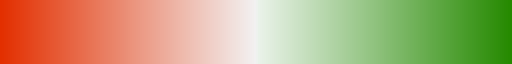

In [2]:
sns.set_style("whitegrid")
sns.set_palette("muted")
hm_w = 10
hm_h = 4
set_title = False
sns.set(font_scale = 1.8)
my_cmap = sns.diverging_palette(15, 125, s=100, l=50, as_cmap=True)
my_cmap

In [3]:
con = duckdb.connect()
grouping_cols = ['count', 'columns', 'col_width', 'category']

# Functions

In [4]:
def load_csv(con, csv_path, median_cols):
    q = "select "
    q += ", ".join(grouping_cols)
    q += ", " + ", ".join([f"median({c}) as {c}" for c in median_cols])
    q += f" from read_csv_auto('{csv_path}') "
    q += "group by " + ", ".join(grouping_cols)
    q += " order by " + ", ".join(grouping_cols)
    con.execute(q)
    return con.fetchdf()

In [5]:
def compute_relative_runtime(con, df, cat1, cat2, col):
    q = "select\n\tcast(log2(c1.count) as int) as row_count,"
    q += f"\n\tc1.columns,\n\tc1.col_width,\n\tc1.{col} as {cat1}_{col},\n\tc2.{col} as {cat2}_{col},"
    q += f"\n\tround(c1.{col} / c2.{col}, 2) as relative_runtime"
    q += f"\nfrom\n\tdf c1,\n\tdf c2"
    q += f"\nwhere\n\tc1.category = '{cat1}'\nand\tc2.category = '{cat2}'\nand\t"
    q += "\nand\t".join([f"c1.{c} = c2.{c}" for c in grouping_cols[:-1]])
    q += "\norder by\n\trow_count,\n\t"
    q += ",\n\t".join([f"c1.{c}" for c in grouping_cols[1:-1]])
    con.execute(q)
    return con.fetchdf()

In [6]:
def create_heatmap(df, columns, title, fname):
    fig, ax = plt.subplots(figsize=(hm_w, hm_h))
    g = sns.heatmap(df.pivot(columns[0], columns[1], columns[2]), linewidths=1, center=1, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
    g.invert_yaxis()
    labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    if set_title:
        plt.title(f'Relative runtime of {title}')
    plt.savefig(f'figures/{fname}.eps', bbox_inches="tight")
    plt.show()

# Reordering

In [188]:
reorder_df = load_csv(con, 'results/reorder.csv', ['total', 'reorder', 'scatter', 'gather'])
con.execute("select category, sum(total) from reorder_df group by category")
con.fetchdf()

,category,sum(total)
0,col,113439208.0
1,row,247881749.0


In [189]:
reorder_total_df = compute_relative_runtime(con, reorder_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from reorder_total_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.475556,0.46


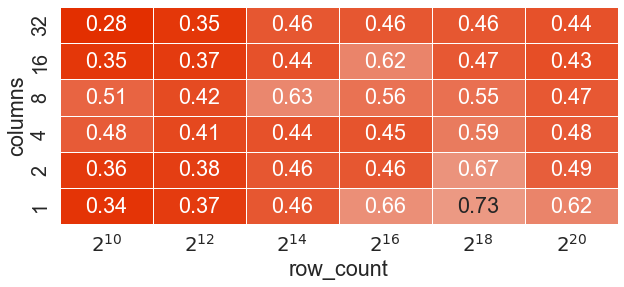

In [190]:
create_heatmap(reorder_total_df,
               ['columns', 'row_count', 'relative_runtime'],
               'payload reordering rows vs. columns (incl. scatter + gather)',
               'reorder_incl_sg')

In [191]:
reorder_only_df = compute_relative_runtime(con, reorder_df, 'col', 'row', 'reorder')
con.execute("select avg(relative_runtime), median(relative_runtime) from reorder_only_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.736667,1.49


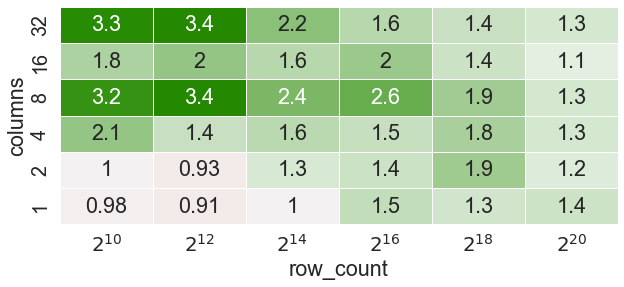

In [192]:
create_heatmap(reorder_only_df,
               ['columns', 'row_count', 'relative_runtime'],
               'payload reordering rows vs. columns (excl. scatter + gather)',
               'reorder_excl_sg')

In [193]:
con.execute("""
    select
        cast(log2(count) as int) as row_count,
        columns,
        col_width,
        reorder as "row reorder",
        round(cast(scatter + gather as double) / total, 2) as sg
    from
        reorder_df
    where
        category = 'row'
    order by
        row_count asc,
        columns asc
""")
reorder_percentage_df = con.fetchdf()
con.execute('select avg(sg), median(sg) from reorder_percentage_df')
con.fetchdf()

,avg(sg),median(sg)
0,0.688889,0.67


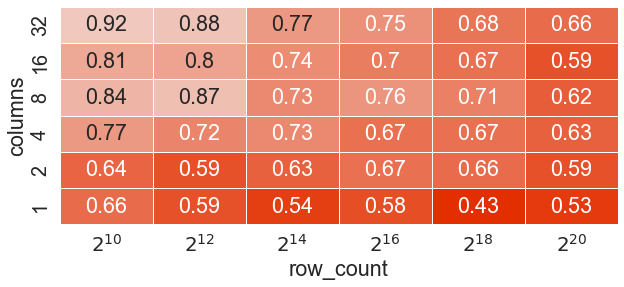

In [194]:
create_heatmap(reorder_percentage_df,
               ['columns', 'row_count', 'sg'],
               'scatter + gather as percentage of reorder runtime',
               'reorder_sg_percentage')

# Comparator

In [195]:
comparator_df = load_csv(con, 'results/comparator.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(total) from comparator_df group by category")
con.fetchdf()

,category,sum(total)
0,col,886666621.0
1,col_ss,236780539.0
2,row_branched,536309296.0
3,row_branchless,308703502.0


In [196]:
comparator_col_iter_df = compute_relative_runtime(con, comparator_df, 'col', 'col_ss', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_col_iter_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,2.795556,2.875


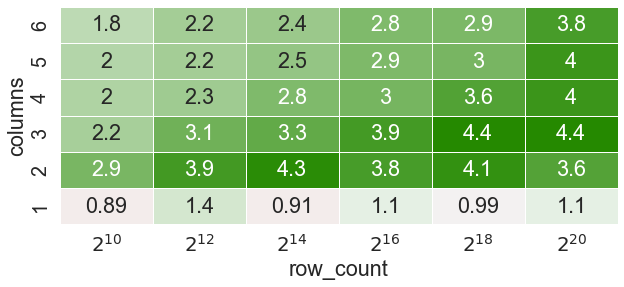

In [197]:
create_heatmap(comparator_col_iter_df,
               ['columns', 'row_count', 'relative_runtime'],
               'columnar_iterative vs. columnar_all (pdqsort)',
               'comparator_col_iter')

In [198]:
comparator_row_key_df = compute_relative_runtime(con, comparator_df, 'col_ss', 'row_branched', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_row_key_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.521667,0.485


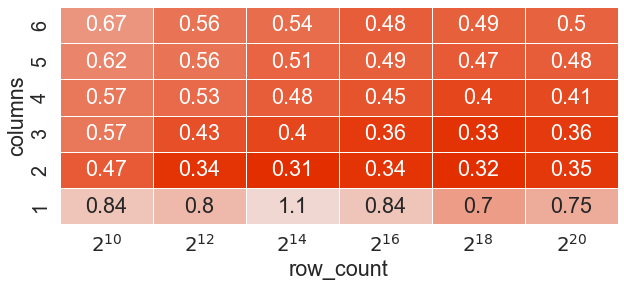

In [199]:
create_heatmap(comparator_row_key_df,
               ['columns', 'row_count', 'relative_runtime'],
               'row_key vs. columnar_iterative (pdqsort)',
               'comparator_row_key')

In [202]:
comparator_norm_key_df = compute_relative_runtime(con, comparator_df, 'col_ss', 'row_branchless', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_norm_key_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.7925,0.825


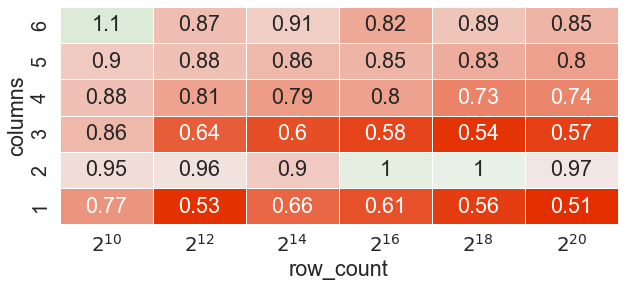

In [203]:
create_heatmap(comparator_norm_key_df,
               ['columns', 'row_count', 'relative_runtime'],
               'normalized_key vs. columnar_iterative (pdqsort)',
               'comparator_norm_key')

# Sort

In [204]:
sort_df = load_csv(con, 'results/sort.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(sort) from sort_df group by category")
con.fetchdf()

,category,sum(sort)
0,pdq_dynamic,471745087.0
1,pdq_static,273511623.0
2,radix,294371084.0


In [205]:
sort_static_radix_df = compute_relative_runtime(con, sort_df, 'pdq_static', 'radix', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from sort_static_radix_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.724167,0.79


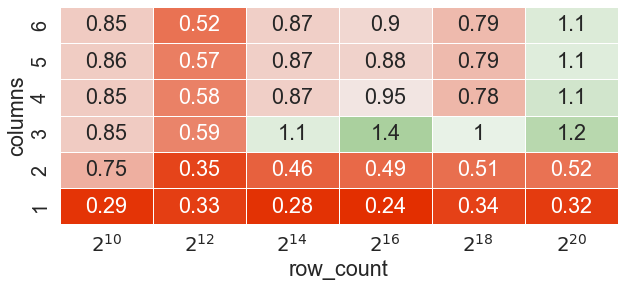

In [206]:
create_heatmap(sort_static_radix_df,
               ['columns', 'row_count', 'relative_runtime'],
               'pdq_static vs. radix',
               'sort_static')

In [207]:
sort_dynamic_radix_df = compute_relative_runtime(con, sort_df, 'pdq_dynamic', 'radix', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from sort_dynamic_radix_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.605556,1.34


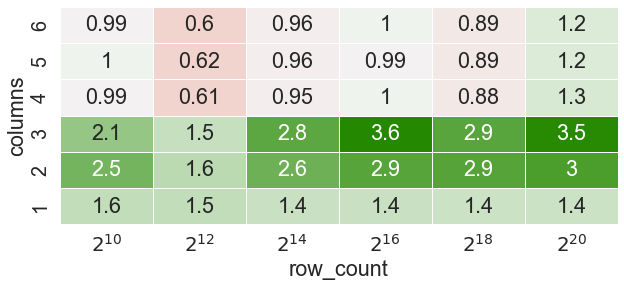

In [208]:
create_heatmap(sort_dynamic_radix_df,
               ['columns', 'row_count', 'relative_runtime'],
               'pdq_dynamic vs. radix',
               'sort_dynamic')

# Merge Key

In [209]:
merge_key_df = load_csv(con, 'results/merge_key.csv', ['total'])
con.execute("select category, sum(total) from merge_key_df group by category")
con.fetchdf()

,category,sum(total)
0,col,37865497.0
1,row,31218208.0


In [210]:
merge_key_runtime = compute_relative_runtime(con, merge_key_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_key_runtime")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.272778,1.32


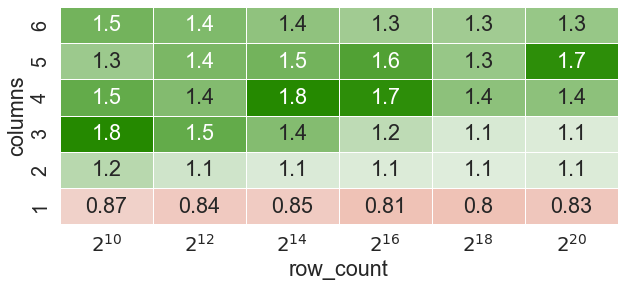

In [211]:
create_heatmap(merge_key_runtime,
               ['columns', 'row_count', 'relative_runtime'],
               'merge normalized key vs. merge key columnar',
               'merge_key')

# Merge Payload

In [212]:
merge_payload_df = load_csv(con, 'results/merge_payload.csv', ['total'])
con.execute("select category, sum(total) from merge_payload_df group by category")
con.fetchdf()

,category,sum(total)
0,col,163023540.0
1,row,145612459.0


In [213]:
merge_payload_runtime_df = compute_relative_runtime(con, merge_payload_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_payload_runtime_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.977222,0.835


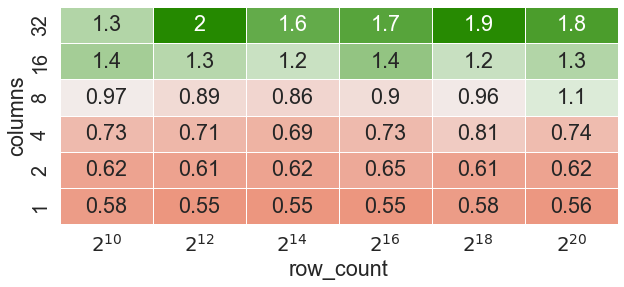

In [214]:
create_heatmap(merge_payload_runtime_df,
               ['columns', 'row_count', 'relative_runtime'],
               'merging rows vs. merging columns',
               'merge')

# Trace

In [29]:
# TODO

# Templating ...

In [80]:
for i in range(1, 33):
    print(f'case {i}:')
    print(f'return memcpy_fixed_<{i}>(a1, a2);')

case 1:
return memcpy_fixed_<1>(a1, a2);
case 2:
return memcpy_fixed_<2>(a1, a2);
case 3:
return memcpy_fixed_<3>(a1, a2);
case 4:
return memcpy_fixed_<4>(a1, a2);
case 5:
return memcpy_fixed_<5>(a1, a2);
case 6:
return memcpy_fixed_<6>(a1, a2);
case 7:
return memcpy_fixed_<7>(a1, a2);
case 8:
return memcpy_fixed_<8>(a1, a2);
case 9:
return memcpy_fixed_<9>(a1, a2);
case 10:
return memcpy_fixed_<10>(a1, a2);
case 11:
return memcpy_fixed_<11>(a1, a2);
case 12:
return memcpy_fixed_<12>(a1, a2);
case 13:
return memcpy_fixed_<13>(a1, a2);
case 14:
return memcpy_fixed_<14>(a1, a2);
case 15:
return memcpy_fixed_<15>(a1, a2);
case 16:
return memcpy_fixed_<16>(a1, a2);
case 17:
return memcpy_fixed_<17>(a1, a2);
case 18:
return memcpy_fixed_<18>(a1, a2);
case 19:
return memcpy_fixed_<19>(a1, a2);
case 20:
return memcpy_fixed_<20>(a1, a2);
case 21:
return memcpy_fixed_<21>(a1, a2);
case 22:
return memcpy_fixed_<22>(a1, a2);
case 23:
return memcpy_fixed_<23>(a1, a2);
case 24:
return memcpy_fixed_